In [1]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 21.1 MB/s eta 0:00:00


In [2]:
!uv pip install torch torchvision -q

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

МАСКА ИСКЛЮЧЕНИЯ ИЗ ВНИМАНИЯ БАННЕРОВ

In [5]:
def create_text_mask_by_location(image):
    h, w = image.shape[:2]
    # Создаем пустую маску (255 - область интереса, 0 - текст/баннеры)
    text_mask = np.ones((h, w), dtype=np.uint8) * 255

    # Координаты баннеров (исправленные на основе предположений)
    # Первый баннер: [45, 474] (x1, y1) и [334, 524] (x2, y2)
    x1, y1 = min(45, 334), min(474, 524)  # Верхний левый угол
    x2, y2 = max(45, 334), max(474, 524)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0

    # Второй баннер: [879, 2] (x1, y1) и [1072, 50] (x2, y2)
    x1, y1 = min(879, 1072), min(2, 50)  # Верхний левый угол
    x2, y2 = max(879, 1072), max(2, 50)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0


# Преобразование исходного изображения в HSV для создания маски фона
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Диапазоны для синего фона (настройте под ваш кадр)
    lower_blue = np.array([100, 200, 150])  # Уточненный диапазон для синего
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # Инвертируем маску фона (0 - синий фон, 255 - остальное)
    mask_blue = cv2.bitwise_not(mask_blue)

    # Объединяем маску баннеров и маску фона
    final_mask = cv2.bitwise_and(text_mask, mask_blue)

    print("Маска фона (0 - синий фон, 255 - остальное):")
    cv2_imshow(mask_blue)
    print("Итоговая маска (баннеры + фон):")
    cv2_imshow(final_mask)

    return final_mask



`МАСКА ДЛЯ "ДОМА"`

In [34]:
# Новая функция для создания маски "дома"
def create_house_mask(image, text_mask):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Диапазон для "дома"
    lower_house = np.array([110, 50, 75])
    upper_house = np.array([120, 180, 160])

    mask_house = cv2.inRange(hsv, lower_house, upper_house)

    # Применяем маску баннеров, чтобы исключить текст
    mask_house = cv2.bitwise_and(mask_house, mask_house, mask=text_mask)

    # Морфологические операции для улучшения маски
    kernel = np.ones((5, 5), np.uint8)
    mask_house = cv2.morphologyEx(mask_house, cv2.MORPH_OPEN, kernel)  # Удаление шума
    mask_house = cv2.morphologyEx(mask_house, cv2.MORPH_CLOSE, kernel)  # Заполнение разрывов

    print("Маска для дома:")
    cv2_imshow(mask_house)

    # Поиск контуров "дома"
    contours_house, _ = cv2.findContours(mask_house, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Фильтрация контуров по площади
    filtered_contours_house = [cnt for cnt in contours_house if cv2.contourArea(cnt) > 20000]

    return mask_house, filtered_contours_house

МАСКА ДЛЯ КАМНЕЙ (ЖЁЛТЫХ И КРАСНЫХ)

In [35]:
def find_contours_of_cards(image, text_mask):
    # Применяем маску текста, чтобы исключить баннеры
    image_masked = cv2.bitwise_and(image, image, mask=text_mask)

    # Преобразование в HSV для камней
    hsv = cv2.cvtColor(image_masked, cv2.COLOR_BGR2HSV)

    # Диапазоны для желтых камней
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Диапазоны для красных камней (два диапазона, так как красный цвет в HSV делится на два участка)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 230, 230])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 230, 230])
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

# Применяем маску текста к каждой цветной маске
    mask_yellow = cv2.bitwise_and(mask_yellow, mask_yellow, mask=text_mask)
    mask_red = cv2.bitwise_and(mask_red, mask_red, mask=text_mask)

    # Морфологические операции для очистки масок
    kernel = np.ones((5, 5), np.uint8)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, kernel)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, kernel)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

    # Поиск контуров для желтых камней
    contours_yellow, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours_yellow = [cnt for cnt in contours_yellow if 200 < cv2.contourArea(cnt) < 500]

    # Поиск контуров для красных камней
    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours_red = [cnt for cnt in contours_red if 200 < cv2.contourArea(cnt) < 500]

    def filter_circles(contours, mask):
        confirmed_contours = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            roi = mask[y:y+h, x:x+w]
            if roi.shape[0] == 0 or roi.shape[1] == 0:
                continue

            # Улучшенные параметры HoughCircles
            circles = cv2.HoughCircles(
                cv2.cvtColor(image_masked[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY),
                cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                param1=50, param2=15, minRadius=8, maxRadius=40
            )

            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                # Проверяем, соответствует ли круг размеру контура
                for (cx, cy, r) in circles:
                    if abs(r - w/2) < 10 and abs(r - h/2) < 10:  # Проверка на близость к круглой форме
                        confirmed_contours.append(cnt)
                        break
        return confirmed_contours

    # Фильтруем контуры с помощью HoughCircles
    confirmed_yellow = filter_circles(filtered_contours_yellow, mask_yellow)
    confirmed_red = filter_circles(filtered_contours_red, mask_red)

    return confirmed_yellow, confirmed_red, mask_yellow, mask_red

СОЗДАНИЕ АННОТАЦИИ

In [38]:
# Функция создания аннотации
def create_yolo_annotations(contours_yellow, contours_red, contours_house, frame_number, image_shape, output_dir="/content/drive/MyDrive/Sber_Test/1_Энд_Аннотации"):
    img_height, img_width = image_shape[:2]
    annotations_yolo = []
    class_map = {"yellow": 0, "red": 1, "house": 2}  # Добавляем класс для "дома"

    for cnt in contours_yellow:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['yellow']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

    for cnt in contours_red:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['red']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")


    for cnt in contours_house:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['house']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    txt_output_path = os.path.join(output_dir, f"frame_{frame_number}.txt")
    with open(txt_output_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(annotations_yolo))
    print(f"YOLO TXT аннотации сохранены в: {txt_output_path}")

Тестовый кадр, Оригинал


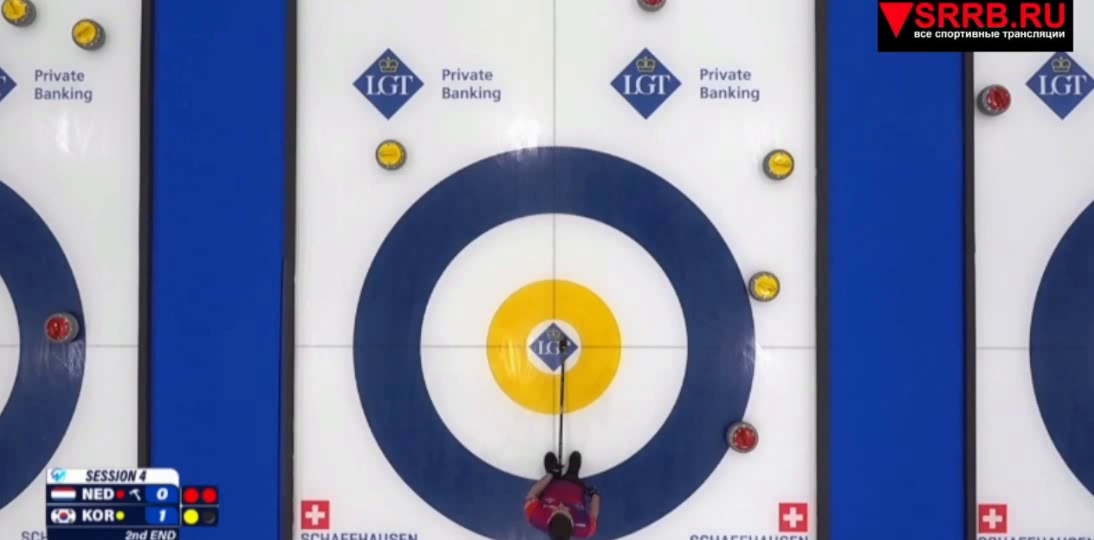

Маска фона (0 - синий фон, 255 - остальное):


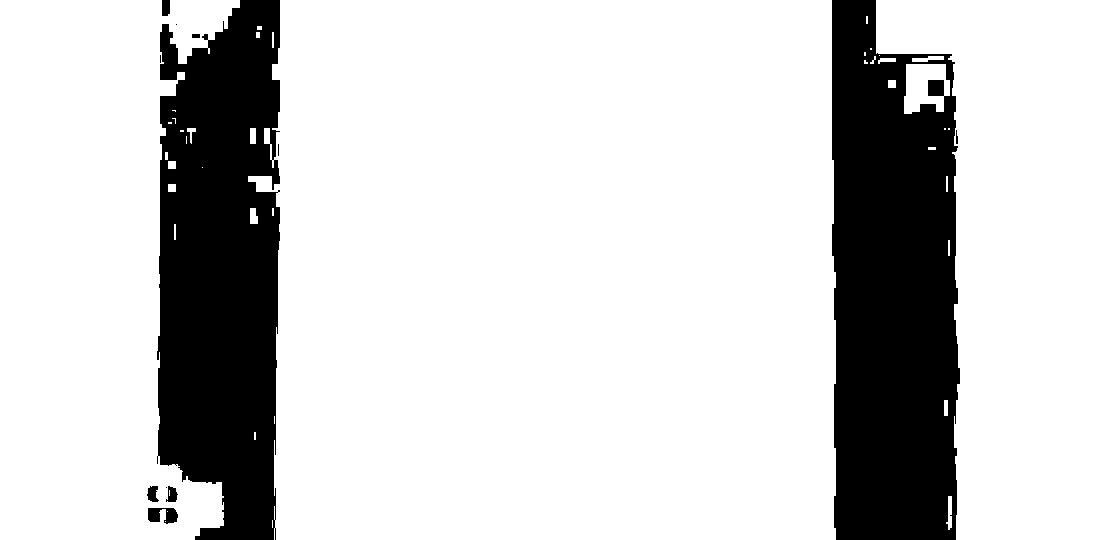

Итоговая маска (баннеры + фон):


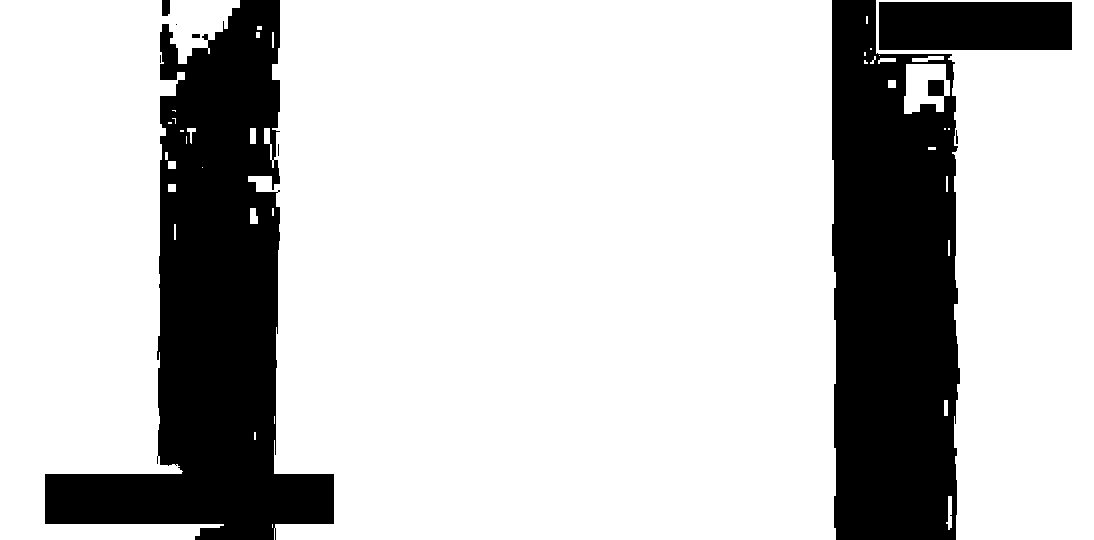

Маска баннеров


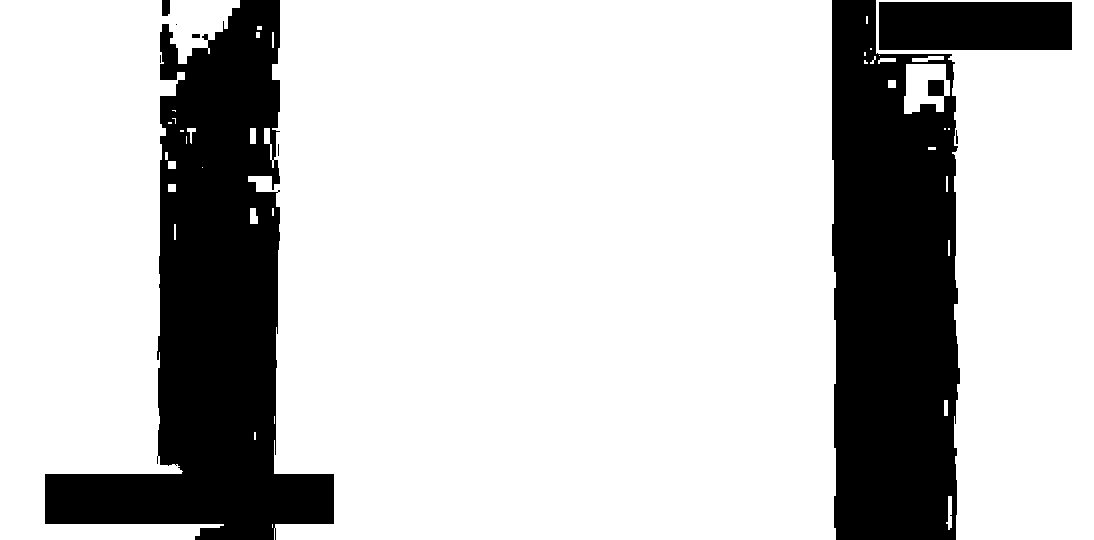

Маска для дома:


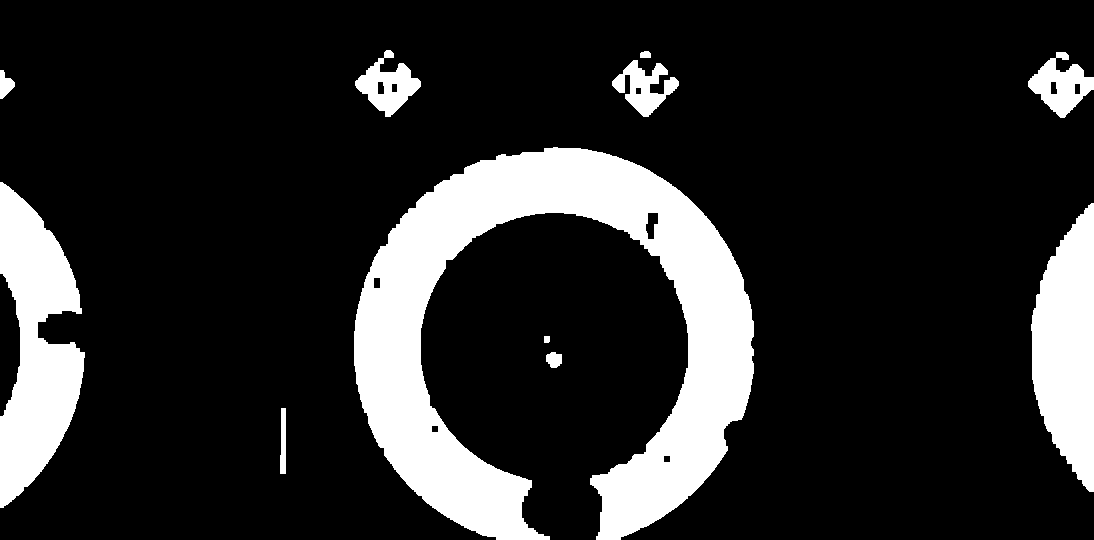

Количество желтых камней: 5
Желтый камень 1: координаты центра (x, y) = (767, 286)
Желтый камень 2: координаты центра (x, y) = (782, 164)
Желтый камень 3: координаты центра (x, y) = (392, 154)
Желтый камень 4: координаты центра (x, y) = (86, 32)
Желтый камень 5: координаты центра (x, y) = (16, 10)
Количество красных камней: 3
Красный камень 1: координаты центра (x, y) = (745, 439)
Красный камень 2: координаты центра (x, y) = (59, 328)
Красный камень 3: координаты центра (x, y) = (998, 98)
Координаты центра дома (x, y) = (554, 343)
Маска для желтых камней


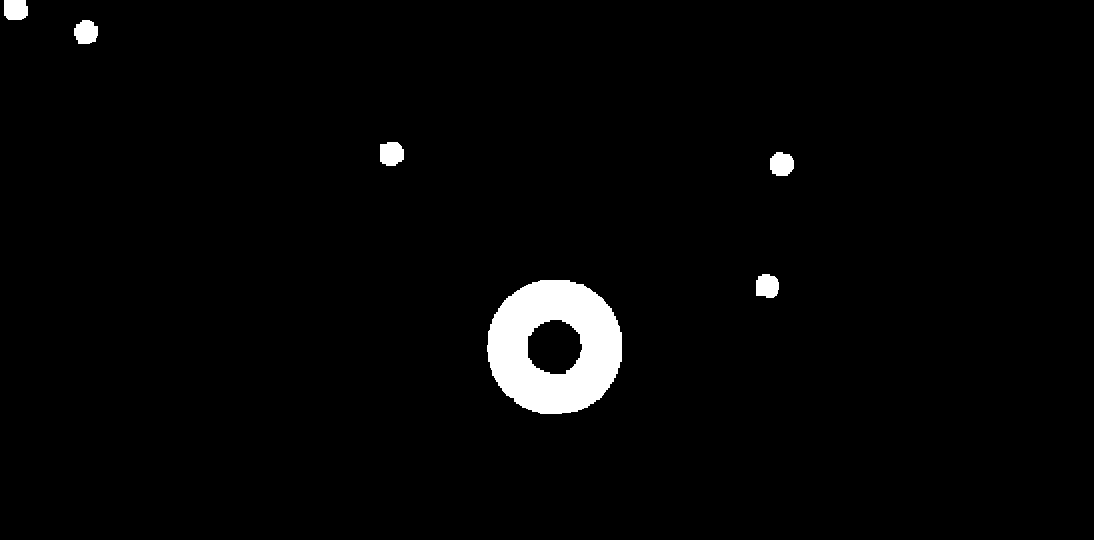

Маска для красных камней


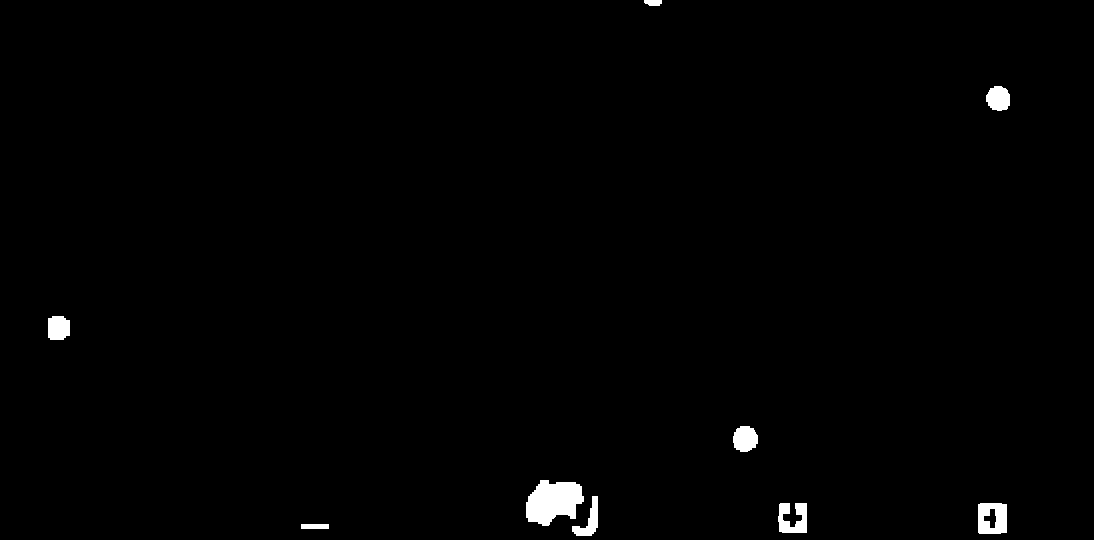

Итоговый кадр с контурами:


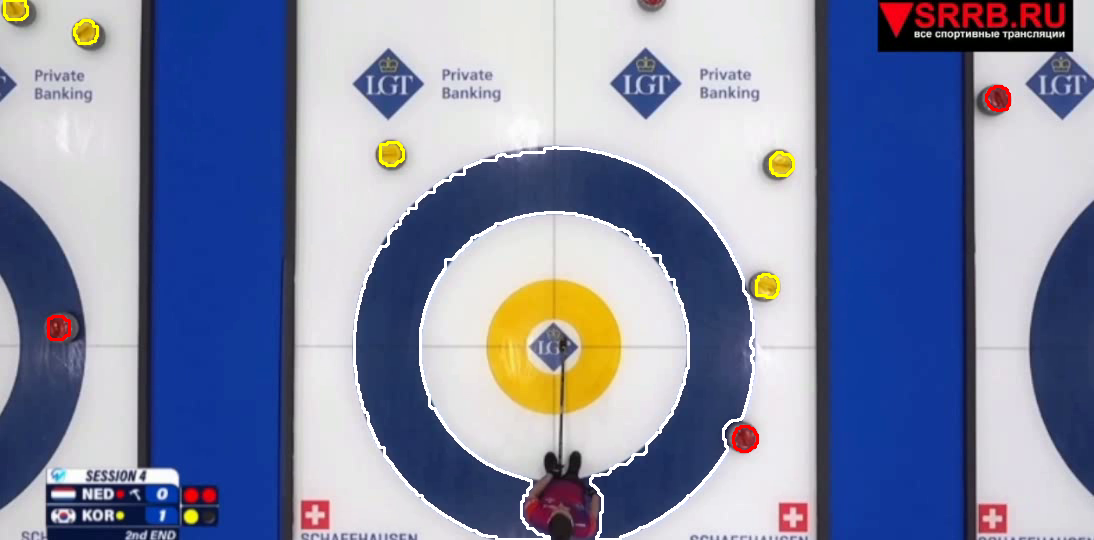

YOLO TXT аннотации сохранены в: /content/drive/MyDrive/Sber_Test/1_Энд_Аннотации/frame_6920.txt


In [40]:
# Основной процесс
video_path = '/content/drive/MyDrive/Sber_Test/1_end.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 6920
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    print("Тестовый кадр, Оригинал")
    cv2_imshow(frame)

    text_mask = create_text_mask_by_location(frame)
    print("Маска баннеров")
    cv2_imshow(text_mask)

    # Создаем маску и контуры для "дома"
    mask_house, contours_house = create_house_mask(frame, text_mask)

    contours_yellow, contours_red, mask_yellow, mask_red = find_contours_of_cards(frame, text_mask)

    print(f"Количество желтых камней: {len(contours_yellow)}")
    for i, cnt in enumerate(contours_yellow):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Желтый камень {i+1}: координаты центра (x, y) = ({x + w//2}, {y + h//2})")

    print(f"Количество красных камней: {len(contours_red)}")
    for i, cnt in enumerate(contours_red):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Красный камень {i+1}: координаты центра (x, y) = ({x + w//2}, {y + h//2})")

    for i, cnt in enumerate(contours_house):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Координаты центра дома (x, y) = ({x + w//2}, {y + h//2})")

    print("Маска для желтых камней")
    cv2_imshow(mask_yellow)
    print("Маска для красных камней")
    cv2_imshow(mask_red)

    contour_image = frame.copy()
    cv2.drawContours(contour_image, contours_yellow, -1, (0, 255, 255), 2)
    cv2.drawContours(contour_image, contours_red, -1, (0, 0, 255), 2)
    cv2.drawContours(contour_image, contours_house, -1, (255, 255, 255), 2)  # Белый цвет для "дома"
    print("Итоговый кадр с контурами:")
    cv2_imshow(contour_image)

    # Создаем YOLO аннотации, включая "дом"
    create_yolo_annotations(contours_yellow, contours_red, contours_house, frame_number, frame.shape)
else:
    print("Ошибка: не удалось извлечь кадр")

cap.release()

СОЗДАНИЕ АННОТАЦИЙ

In [ ]:
def find_contours_of_cards(image):
    # Преобразование в HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    print(f"HSV: ")
    cv2_imshow(frame)

    # Пример диапазона для выделения объектов (например, синих камней)
    lower_range = np.array([100, 150, 0])  # Нижняя граница H, S, V
    upper_range = np.array([140, 255, 255])  # Верхняя граница H, S, V

    mask = cv2.inRange(hsv, lower_range, upper_range)
    print(f"Mask: ")
    cv2_imshow(mask)  # Показать маску

    # Морфологические операции для улучшения маски
    kernel = np.ones((5, 5), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Удаление шума
    print(f"Mask Удалён шум: ")
    cv2_imshow(mask)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Заполнение разрывов
    print(f"Mask Запонены разрывы: ")
    cv2_imshow(mask)

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

Тестовый кадр, Оригинал


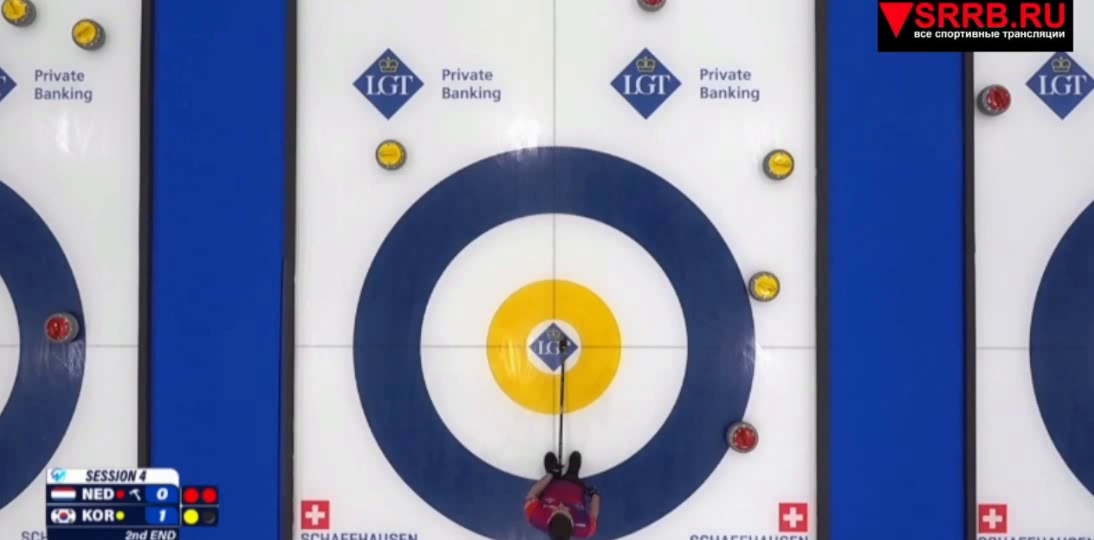

HSV: 


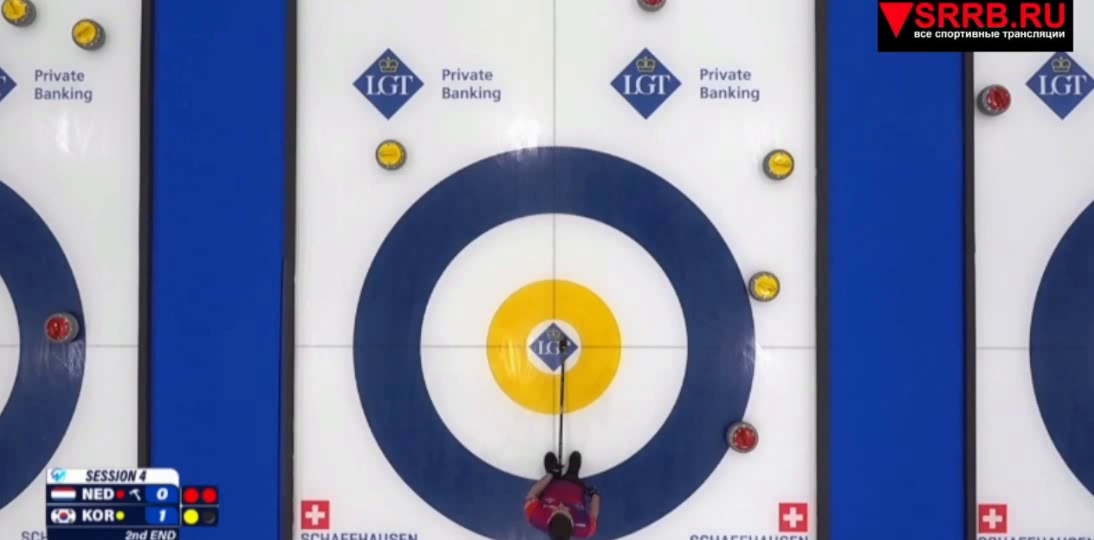

Mask: 


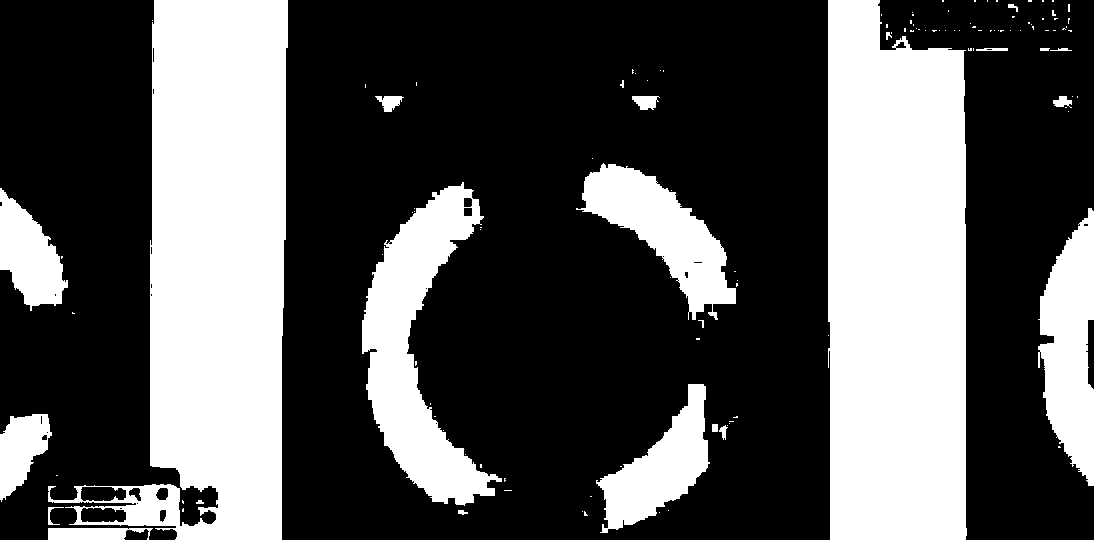

Mask Удалён шум: 


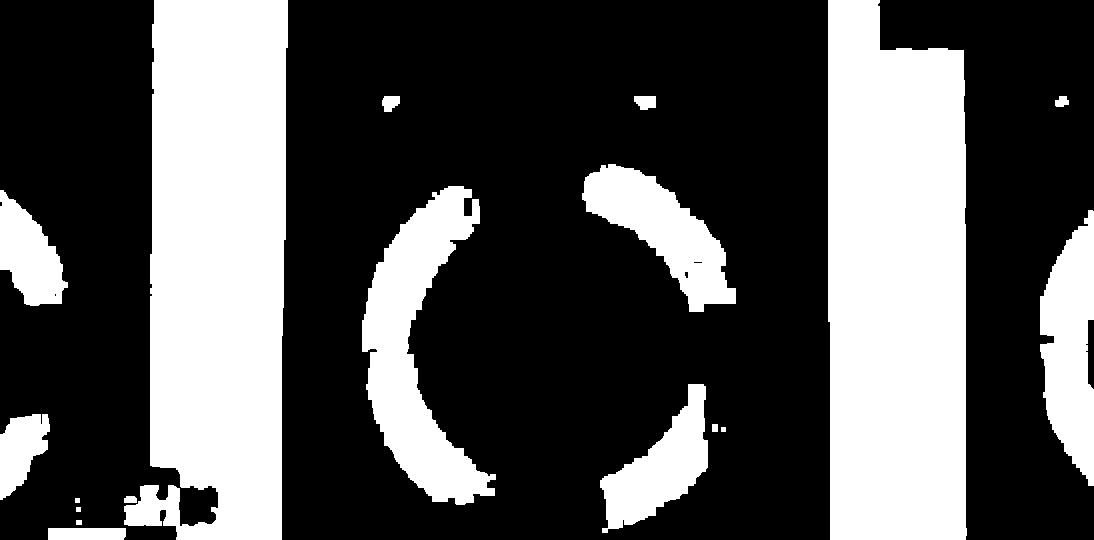

Mask Запонены разрывы: 


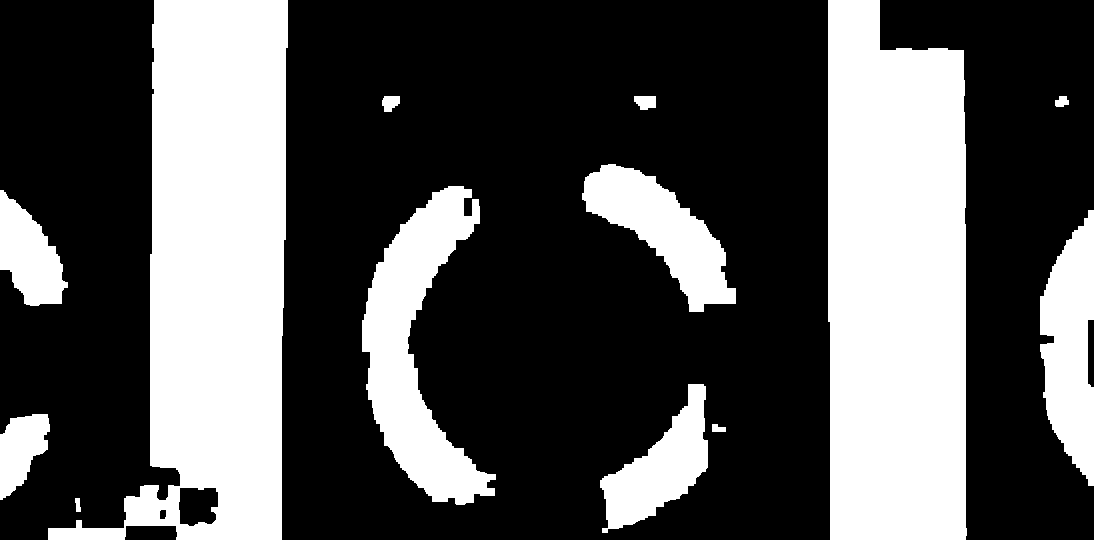

Тестовый кадр, Контур


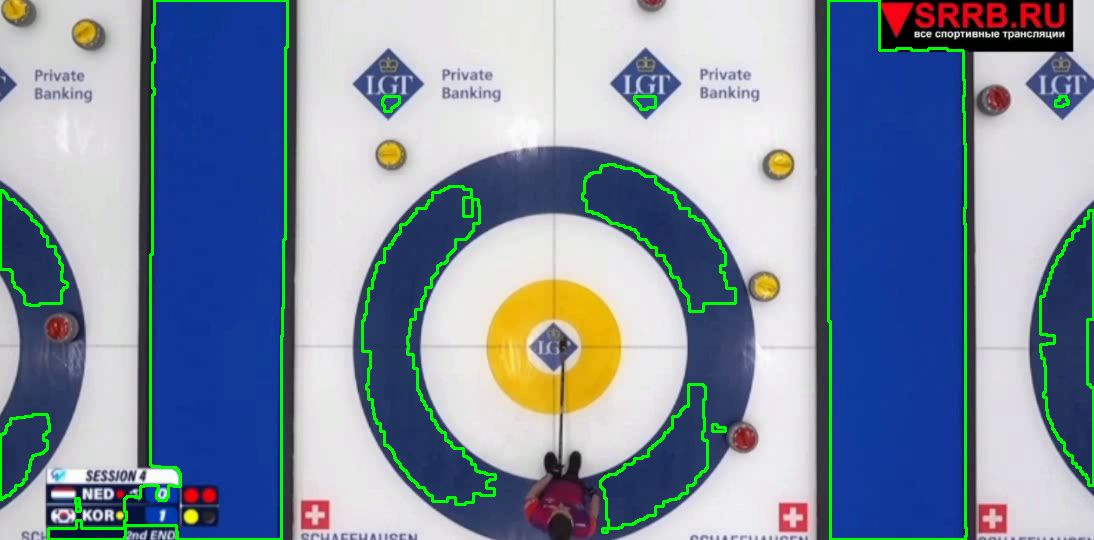

In [8]:
# Загрузка видеофайла и остальной код остается без изменений
video_path = '/content/drive/MyDrive/Sber_Test/1_end.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 6920
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    print("Тестовый кадр, Оригинал")
    cv2_imshow(frame)

    contours = find_contours_of_cards(frame)
    contour_image = frame.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    print("Тестовый кадр, Контур")
    cv2_imshow(contour_image)
else:
    print("Ошибка: не удалось извлечь кадр")

cap.release()